# Rotterdam stylized case

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
#import pickle
import csv
import copy

# IMPORT MODEL CLASSES
from classes import *

from collections import OrderedDict

# Build the model (components of the city)

In [2]:
Rotty = Model('Rotty')
#Add residential areas to the model
Rotty.add_ResidentialArea(ResidentialArea("Area_A",4,["No"],"Residential area A: the Heijplaat"))
Rotty.add_ResidentialArea(ResidentialArea("Area_B",1,["Dike"],"Residential area B: City Centre"))

#Add flood protection objections to the model
Rotty.add_FloodProtection(FloodProtection("No",4,False,"Region without flood protection"))
Rotty.add_FloodProtection(FloodProtection("Dike",4.5,False,"Sea dike"))

Rotty.add_Parameter("alarming_conditions",
       OrderedDict({ #water depth respective to flood protection level, Name of event, reduction of trust if this happens.
                2   : ['Major flood',40], 
                1   : ['Small flood',20],
                0   : ['Near miss',10],
                -0.5  : ['Major wake-up',7],
                -1  : ['Minor wake-up',5],
                -10  : ['Nothing happens',0]
             }))

Rotty

Rotty 
-----------
allFloodProtection: 
No 4; Dike 4.5;  
-----------
allResidentialArea: 
Area_A Protected by:['No']
Area_B Protected by:['Dike']

Parameters : 
{'alarming_conditions': OrderedDict([(2, ['Major flood', 40]), (1, ['Small flood', 20]), (0, ['Near miss', 10]), (-0.5, ['Major wake-up', 7]), (-1, ['Minor wake-up', 5]), (-10, ['Nothing happens', 0])])}

### Load storm surge scenarios

In [3]:
SurgeSeries_A = SurgeSeries(allSurgeSeries,"A",'Scenario A: lower part of RCP4.5',None,None) #Je kunt allSurgeSeries ook gewoon bijhouden in de classes.py
SurgeSeries_B = SurgeSeries(allSurgeSeries,"B",'Scenario B: middle of RCP4.5',None,None)
SurgeSeries_C = SurgeSeries(allSurgeSeries,"C",'Scenario C: middle of RCP8.5',None,None)
SurgeSeries_D = SurgeSeries(allSurgeSeries,"D",'Scenario D: upper part of RCP8.5',None,None)
SurgeSeries_A.from_csv("A.csv")
SurgeSeries_B.from_csv("B.csv")
SurgeSeries_C.from_csv("C.csv")
SurgeSeries_D.from_csv("D.csv")

# Define adaptation strategies (Mayors)

In [6]:
#Create FloodProtectionMeasures
small = Measure("Small dike heightening",0.4,6)
large = Measure("Small dike heightening",1,13)

class Kroket(Mayor):
    def apply_strategy(self,Model,SurgeSeries,i,time):
        global allMeasure
        if Model.allResidentialArea[1].event_impact_history[i] == 7:
            Measure = allMeasure[0]
            
            Dike = Model.allFloodProtection[1]
            
            Dike.measure_history[i] = Measure.increase
            
            Dike.update_protection_level(start=i+Measure.lead_time,end=len(time),newvalue=Dike.protection_level[i]+Measure.increase) 
            
    def get_name(self):
        return('Berry Kroket')

class Bob(Mayor):
    def apply_strategy(self,allResidentialArea,SurgeSeries_name,i,allFloodProtection,time):
        global allMeasure
        
        if allResidentialArea[0].event_impact_history[SurgeSeries_name][i] == 7: #de burgemeester hoeft niet alles te weten    
            allResidentialArea[0].elevation = 10
    
        
        if allResidentialArea[1].event_impact_history[SurgeSeries_name][i] == 7: #de burgemeester hoeft niet alles te weten
            Measure = allMeasure[0]
            
            Dike = allFloodProtection[0]
            
            Dike.measure_history[SurgeSeries.name][i] = Measure.increase #kan beter als function van het object
            
            Dike.update_protection_level(SurgeSeries_name,start=i+Measure.lead_time,end=len(time),newvalue=Dike.protection_level[SurgeSeries_name][i]+Measure.increase) 
    
    
    
    def get_name(self):
        return('Bob the Builder')
    
allMayors = [Kroket(),Bob()]

In [7]:
def run_model(Model,SurgeSeries,Mayor):
    time = SurgeSeries.years
    
    #GET MODEL PARAMETERS
    alarming_conditions = Model.Parameters['alarming_conditions']
    
    #TODO ADD THIS FUNCTIONALITY TO THE FLOODPROTECTIONCLASS
    for FloodProtection in Model.allFloodProtection:
        FloodProtection.protection_level = [FloodProtection.baseline_level] * len(time)
        FloodProtection.measure_history = [None] * len(time)                

    #ADD THE INFORMATION OF THE FLOOD PROTECTION STRUCTURES TO THE AREAS IT PROTECTS
    for Area in Model.allResidentialArea:
        Area.match_with_FloodProtection(Model.allFloodProtection)
    
    #Todo: add this as functionality to the residential area class
    for Area in Model.allResidentialArea:
        #create all the variables that are manipulated over time
        Area.trust_t = [None] * len(time)
        Area.trust_t[0] = Area.trust_0 #set initial condition
        Area.event_impact_history = [None] * len(time) #TO SAVE VALUES OF THE 'ALARMING CONDITIONS'
        Area.flood_history = [None] * len(time) #TO SAVE FLOOD DEPTHS PER YEAR [IN M]

    # THE MODEL RUNS OVER A YEARLY TIMESTEP
    for i,t in enumerate(time): #Iterate over the years t, with index i
        #print(i,t)

        for Area in Model.allResidentialArea:
            #FIRST EVALUATE IF THE FLOOD PROTECTION LEVEL IS EXCEEDED (TO DETERMINE IF FLOOD HAPPENS)
            if Area.protection_level[i] < SurgeSeries.surgelevel[i]: #if a flood occurs
                Area.flood_history[i] = SurgeSeries.surgelevel[i] - Area.elevation
                #print("{} is inundated with a water depth of {} m \n --> damage occurs".format(Area.name,Area.flood_history[i]))

            #THEN EVALUATE THE IMPACT ON TRUST
            if i != 0: #don't evaluate trust in the first timestep!
                #print(Area.protection_level-levels_t[i])
                Area.event_impact_history[i] = evaluate_event(SurgeSeries.surgelevel[i]-Area.protection_level[i],alarming_conditions,False)
                #First evaluate the impact of this year's event (if any)

                Area.trust_t[i] = Area.trust_t[i-1] - Area.event_impact_history[i]

                #ALWAYS MODEL RECOVERY OF TRUST
                k = 0.2 #bovenaan definieren
                T_eq = 70
                dTdt = (Area.trust_t[i]-T_eq)*-k
                Area.trust_t[i] = Area.trust_t[i] + dTdt

        #IMPLEMENT FLOOD PROTECTION MEASURES
        Mayor.apply_strategy(Model,SurgeSeries,i,time)

        for Area in Model.allResidentialArea:
               Area.match_with_FloodProtection(Model.allFloodProtection)
    
    #RETURN OUTCOMES OF THE MODEL
    experiment = OrderedDict({
        "model_name" : Model.name,
        "Model" : copy.deepcopy(Model),
        "SurgeSeries" : copy.deepcopy(SurgeSeries),
        "Mayor" : copy.deepcopy(Mayor)
    })
    
    return experiment

experiments = []
for SurgeSeries in allSurgeSeries:
    experiment = run_model(Rotty,SurgeSeries,Kroket())
    experiments.append(experiment)

In [8]:
len(experiments)

4

D
C
B
A


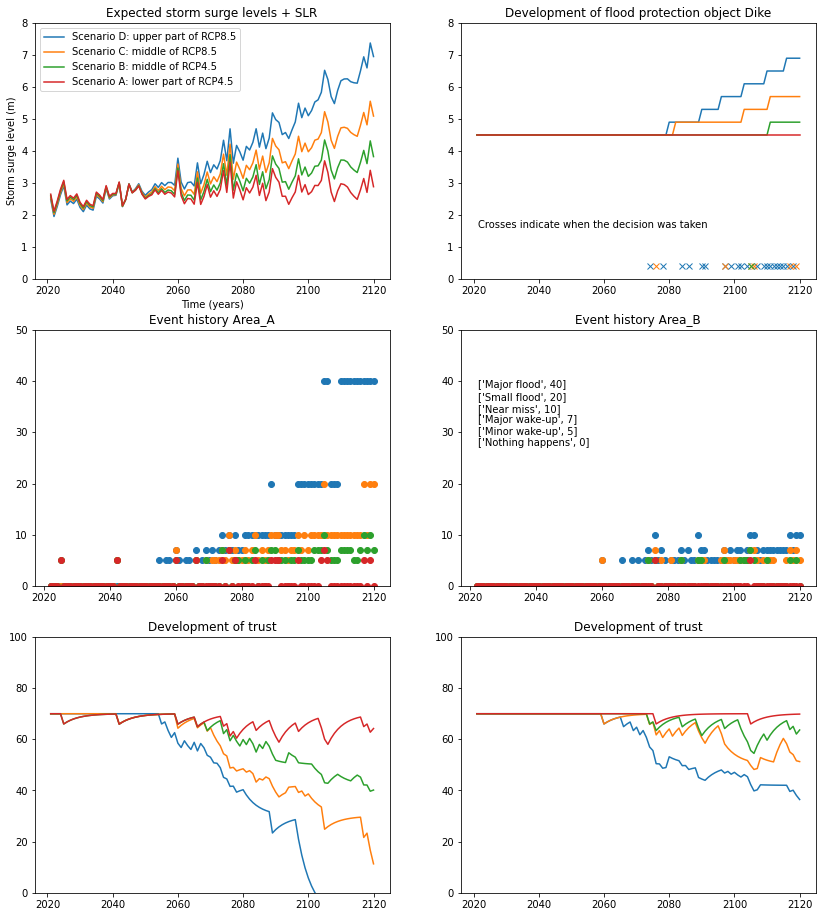

In [9]:
fig, axes = plt.subplots(nrows=3,ncols=2,sharey=False,figsize=(14,16))

labels = []

for experiment in reversed(experiments):
    
    Model = experiment['Model']
    SurgeSeries = experiment['SurgeSeries']
    Mayor = experiment['Mayor']
    
    print(SurgeSeries.name)
    
    axes[0,0].plot(SurgeSeries.years,SurgeSeries.surgelevel)

    labels.append(SurgeSeries.description)
    axes[0,0].set_title('Expected storm surge levels + SLR')
    axes[0,0].set_xlabel('Time (years)')
    axes[0,0].set_ylabel('Storm surge level (m)')
    axes[0,0].set_ylim(0,8)
    axes[0,1].set_ylim(0,8)

    for i, Area in enumerate(Model.allResidentialArea):
        axes[1,i].set_title('Event history {}'.format(Model.allResidentialArea[i].name))
        axes[1,i].plot(SurgeSeries.years,Model.allResidentialArea[i].event_impact_history,'o')
        axes[1,i].set_ylim(0,50)
        
        axes[2,i].set_title('Development of trust')
        axes[2,i].plot(SurgeSeries.years,Model.allResidentialArea[i].trust_t)

        axes[2,i].set_ylim(0,100)
    

    axes[0,1].plot(SurgeSeries.years,Model.allFloodProtection[1].protection_level)
    axes[0,1].set_title('Development of flood protection object Dike')
    
axes[0,0].legend(labels)

#Add some additional text to some axes
alarming_conditions = Model.Parameters['alarming_conditions']

textbox = ""
for key in alarming_conditions:
    textbox = textbox + str(alarming_conditions[key]) + '\n'

axes[0,1].text(0.05,0.2,"Crosses indicate when the decision was taken",transform=axes[0,1].transAxes)
axes[1,1].text(0.05,0.5,textbox,transform=axes[1,1].transAxes)


axes[0,1].set_prop_cycle(None) #reset the cycler to plot again in the same axes with similar colors
for experiment in reversed(experiments):
    Model = experiment['Model']
    SurgeSeries = experiment['SurgeSeries']
    Mayor = experiment['Mayor']    
    
    axes[0,1].plot(SurgeSeries.years,Model.allFloodProtection[1].measure_history,'x') #PLOT THE HISTORY OF THE MEASURES
    